In [56]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import seaborn as sns
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from random import random
import copy

In [27]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [28]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [29]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [30]:
np.random.seed(0)
sample_playlists = np.random.choice(playlists, 500, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [31]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 33226
Number of Artists: 6723


In [32]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
047,1,1
10 Years,1,1
10cc,1,1
112,1,1
...,...,...
David Grisman,289,1
Jethro Tull,323,4
Neil Young,371,4


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [33]:
artists = appearances[appearances['playlistname']>=5].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 277


In [131]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1.head(10)

,user_id,artistname,trackname,playlistname
53146,0921245fb4097477109ed35ca4d684e4,Various Artists,Tarbolton,Fiddle Favourites
85480,424678a7d04868568c9f95863a901d88,Robin Thicke,Blurred Lines,heartlifting
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
85487,424678a7d04868568c9f95863a901d88,Kylie Minogue,I Believe In You,heartlifting
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
110332,26916a44c7af854db436d562704b88a1,Queen,Somebody To Love (Live In Montreal),Don Diablo
156728,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Bad (feat. Vassy) - Radio Edit,David Guetta — Listen (Deluxe)
156729,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Bang my Head (feat. Sia),David Guetta — Listen (Deluxe)
156730,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Dangerous (feat. Sam Martin),David Guetta — Listen (Deluxe)


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [35]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [129]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2.head(10)

,user_id,artistname,trackname,playlistname
85480,424678a7d04868568c9f95863a901d88,Robin Thicke,Blurred Lines,heartlifting
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
85487,424678a7d04868568c9f95863a901d88,Kylie Minogue,I Believe In You,heartlifting
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
110332,26916a44c7af854db436d562704b88a1,Queen,Somebody To Love (Live In Montreal),Don Diablo
200315,851f4dce324bc81546ccde8a360db07f,Incubus,A Crow Left of the Murder,run
200322,851f4dce324bc81546ccde8a360db07f,Vampire Weekend,Cousins,run
200323,851f4dce324bc81546ccde8a360db07f,Alice In Chains,Dam That River,run
200331,851f4dce324bc81546ccde8a360db07f,Pearl Jam,Got Some,run


In [130]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play.head(10)


,artistname,playlistname
0,!!!,1
1,047,1
2,10 Ft. Ganja Plant,1
3,10 Years,1
4,10cc,1
5,112,1
6,12 Stones,1
7,1349,1
8,1910 Fruitgum Company,1
9,1999,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

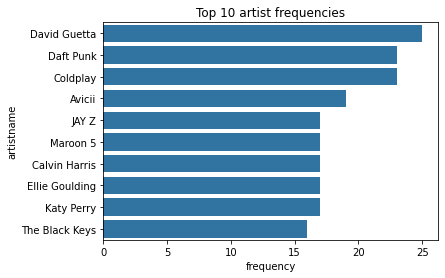

In [38]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

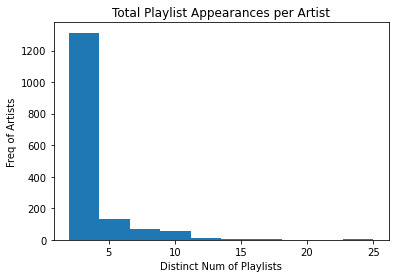

In [39]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [40]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [41]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: total: 62.5 ms
Wall time: 58 ms


In [42]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: total: 219 ms
Wall time: 212 ms


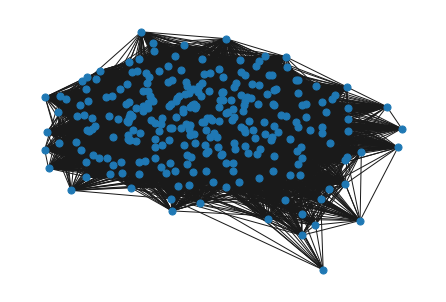

In [43]:
%%time
nx.draw(G, node_size=50)


In [44]:
# # [n for n in G.neighbors]
# neighbors = []
# for i in G.nodes:
#     count = 0
#     for k in G.neighbors(i):
#         count += 1
#     neighbors.append(count)
# neigh_df = pd.DataFrame(G.nodes)
# neigh_df['neighbors'] = neighbors
# neigh_df
# plt.hist(neigh_df['neighbors'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Node Count')
# plt.title('Node Freq of Neighbor Count')
# plt.savefig('node_freq')

In [45]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Justin Timberlake' in i:
        weight_dict[i] = node_weights[i]

In [128]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)[:10]

[(('Maroon 5', 'Justin Timberlake'), 7),
 (('Justin Timberlake', 'JAY Z'), 7),
 (('Justin Timberlake', 'Katy Perry'), 6),
 (('Justin Timberlake', 'P!nk'), 6),
 (('Beyoncé', 'Justin Timberlake'), 5),
 (('Pitbull', 'Justin Timberlake'), 5),
 (('Rihanna', 'Justin Timberlake'), 5),
 (('Justin Timberlake', 'The Black Keys'), 5),
 (('Justin Timberlake', 'Miike Snow'), 5),
 (('Justin Timberlake', 'Passenger'), 5)]

In [47]:
len(G.nodes)

277

In [48]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [49]:
genres = get_artist_genres(list(G.nodes))

In [127]:
df2[df2['artistname']=='Phoenix'].head(10)

,user_id,artistname,trackname,playlistname
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
937729,79c900d50f847451c38c9dcc328f74a6,Phoenix,Lisztomania,"New Year's Eve, Or, You Forgot What You Meant ..."
4665563,005241c63412ee4be1955b05faf301dc,Phoenix,If I ever feel better,Gosts 'n Stuff
5427717,cb464738d626baae611fc49584b44003,Phoenix,1901,kawaii
5427778,cb464738d626baae611fc49584b44003,Phoenix,Fences,kawaii
5427840,cb464738d626baae611fc49584b44003,Phoenix,Lisztomania,kawaii
6927306,f21063758c53d4812a9ba89958bc4d61,Phoenix,Lisztomania,VPB
9969461,9ccb672668dd60a1a8eb72303476687e,Phoenix,1901,boyhood soundtrack
10300804,8f0796ba6cb8b1fe4d8d69847c6a2a90,Phoenix,1901,/* End of Week */
10503755,bd18a55339aa49e842dd55af9d30487d,Phoenix,Too young,loreley playlist


In [51]:
# implement algorithm
def standardize_matrix(A):
    max_edge = 0
    for i in nx.to_numpy_array(G):
        if (max(i)) > max_edge:
            max_edge = max(i)
    stand_A = []
    for row in nx.to_numpy_array(G):
        stand_row = []
        for edge in row:
            stand_row.append(edge/max_edge)
        stand_A.append(stand_row)
    return np.array(stand_A)


In [120]:
## algorithm work

# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return -log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100, alpha = .005, lambda_W = .001):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    F_new = np.zeros((N,C))
    X = Att
    W = np.random.rand(Att.shape[1], C)
    W_new = np.zeros((Att.shape[1], C))
    ll = .01
    ll_new = 0
    Q = np.zeros((F.shape[0], W.shape[0]))
    Sanity = np.zeros((F.shape[0], W.shape[0]))
    for n in range(iterations):
        for u in range(Q.shape[0]):
            for k in range(Q.shape[1]):
                running_sum = 0
                for c in range(F.shape[1]):
                    running_sum += W[k][c] * F[u][c]
                Q[u][k] = 1/(1+np.exp(-running_sum))
        
        for u in range(X.shape[0]):
            grad = gradient(F, A, u)
            for c in range(F.shape[1]):
                running_sum = 0
                for k in range(X.shape[1]):
                    running_sum += (X[u][k] - Q[u][k]) * W[k][c]
                F_new[u][c] = max(.001, F[u][c] + alpha*(running_sum + grad[c]))
        
        for k in range(X.shape[1]):
            for c in range(F.shape[1]):
                running_sum = 0
                for u in range(F.shape[0]):
                    running_sum += (X[u][k] - Q[u][k]) * F[u][c]
                W_new[k][c] = W[k][c] + alpha * running_sum - alpha * lambda_W * np.sign(W[k][c])
                
        F = copy.deepcopy(F_new)
        W = copy.deepcopy(W_new)
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(np.maximum(.001, X*np.log(np.maximum(.001, Q)) + (1 - X)*np.log(np.maximum(.001, 1 - Q))))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
        else:
            ll = ll_new
    delta = (-np.log(1 - (1/N)))**.5
    
    return F > delta, W

In [126]:
A = (nx.to_numpy_array(G) >= 5) * 1 # binary adjacency matrix
att = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))) >= 10}) * 1
att = np.array([pd.Series([node for node in G.nodes]).apply(lambda x: dict(zip(att.index, att.playlistname))[x])]).T
# pred = np.argmax(train(A, att, 3),1)
F, W = train(A, att, 3)
np.argmax(F,1), W

(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2,
        1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[0.49908955, 0.74789203, 0.50455111]]))

In [125]:
A = nx.to_numpy_array(G)
A = standardize_matrix(A)

# attr_mat = np.array([[1 for node in G.nodes()]]).T
# pred = np.argmax(train(A, att, 3), 1)
F, W = train(A, att, 3, 50)
np.argmax(F,1), W

C:\Users\tranb\AppData\Local\Temp\ipykernel_12820\1432577190.py:67: RuntimeWarning: overflow encountered in exp
  Q[u][k] = 1/(1+np.exp(-running_sum))


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[25.74755199, 11.92134864,  3.98739259]]))

In [42]:
# perform bigclam algorithm
# start = time.time()
# F, ll = train(A, 5) # 3 is number of groups
# pred = np.argmax(F, 1)
# end = time.time()
# print(end - start)
pred

array([[0, 0, 0],
       [5, 5, 5]])

In [32]:
nodes = [node for node in G]
nodes_pred = dict(zip(nodes, pred))


In [33]:
# calc percent of top edges are in the same group
dict_nodes_edg_grp = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in nodes:
    dict_nodes_edg_grp[i] = []
    weight_dict = {}
    for j in node_weights:
        if i in j:
            weight_dict[j] = (node_weights[j], [nodes_pred[j[0]], nodes_pred[j[0]]])
    weight_dict = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
    dict_nodes_edg_grp[i].append(weight_dict[:3])


In [34]:
sorted(nodes_pred.items(), key=lambda x:x[1], reverse=True)

[('LCD Soundsystem', 2),
 ('The Smashing Pumpkins', 2),
 ('Romeo Santos', 2),
 ('The New Pornographers', 2),
 ('Ice Cube', 2),
 ('Marvin Gaye', 2),
 ('Cat Power', 1),
 ('Survivor', 1),
 ('Coolio', 1),
 ('Oasis', 1),
 ('Radiohead', 1),
 ('Faul & Wad Ad', 1),
 ('Tinie Tempah', 1),
 ('Prince Royce', 1),
 ('R.E.M.', 1),
 ('Drake', 1),
 ('Sam Smith', 1),
 ('Fito Blanko', 1),
 ('Birdy', 1),
 ('Clean Bandit', 1),
 ('Miley Cyrus', 1),
 ('The Glitch Mob', 1),
 ('Aretha Franklin', 1),
 ('blink-182', 1),
 ('Nine Inch Nails', 1),
 ('Wilco', 1),
 ('Various Artists', 1),
 ('The Naked And Famous', 1),
 ('Scorpions', 1),
 ('Steve Aoki', 1),
 ('Lykke Li', 1),
 ('Diddy', 1),
 ('Bob Dylan', 1),
 ('Sia', 1),
 ('MS MR', 1),
 ('The Offspring', 1),
 ('Bryan Adams', 1),
 ('will.i.am', 1),
 ('The National', 1),
 ('Etta James', 1),
 ('Aloe Blacc', 1),
 ('The Chainsmokers', 1),
 ('Adele', 1),
 ('Alejandro Sanz', 1),
 ('Norah Jones', 1),
 ('Labrinth', 1),
 ('Childish Gambino', 1),
 ('Muse', 1),
 ('Maroon 5', 0),


In [157]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Daft Punk' in i:
        weight_dict[i] = (node_weights[i], [nodes_pred[i[0]], nodes_pred[i[1]]])
        

In [158]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Daft Punk', 'Katy Perry'), (10, [0, 1])),
 (('Daft Punk', 'JAY Z'), (9, [0, 2])),
 (('Daft Punk', 'Coldplay'), (9, [0, 0])),
 (('Daft Punk', 'Kanye West'), (8, [0, 2])),
 (('Daft Punk', 'David Guetta'), (8, [0, 1])),
 (('Maroon 5', 'Daft Punk'), (7, [0, 0])),
 (('Rihanna', 'Daft Punk'), (7, [0, 0])),
 (('Daft Punk', 'Madonna'), (7, [0, 0])),
 (('Daft Punk', 'The Black Eyed Peas'), (7, [0, 0])),
 (('Daft Punk', 'Imagine Dragons'), (7, [0, 0])),
 (('Daft Punk', 'Drake'), (7, [0, 0])),
 (('Pitbull', 'Daft Punk'), (6, [0, 0])),
 (('Daft Punk', 'Queen'), (6, [0, 0])),
 (('Daft Punk', 'Britney Spears'), (6, [0, 0])),
 (('Daft Punk', 'Michael Jackson'), (6, [0, 0])),
 (('Daft Punk', 'P!nk'), (6, [0, 0])),
 (('Daft Punk', 'Eminem'), (6, [0, 0])),
 (('Daft Punk', 'Usher'), (6, [0, 0])),
 (('Daft Punk', 'Linkin Park'), (6, [0, 0])),
 (('Daft Punk', 'Avicii'), (5, [0, 2])),
 (('Beyoncé', 'Daft Punk'), (5, [0, 0])),
 (('Shakira', 'Daft Punk'), (5, [0, 0])),
 (('Justin Timberlake', 'Daft Punk')

In [78]:
# Node attributes

In [79]:
df2
# avg songs per playlist
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))), 'trackname':'count'})
x['trackname'] / x['playlistname']


artistname
2Pac                 1.500000
Adele                1.888889
Aerosmith            2.500000
Alanis Morissette    1.400000
Alejandro Sanz       3.500000
                       ...   
Zedd                 1.125000
a-ha                 1.400000
blink-182            1.777778
deadmau5             2.700000
will.i.am            2.000000
Length: 277, dtype: float64

In [38]:
# total songs
x = df2.groupby('artistname').agg({'trackname':'count'})
x


,trackname
artistname,
2Pac,15
Adele,17
Aerosmith,15
Alanis Morissette,7
Alejandro Sanz,21
...,...
Zedd,9
a-ha,7
blink-182,16


In [39]:
# song variety - closer to 1: unique song on every playlist, closer to 0: many songs in common over playlists
x = df2.groupby('artistname').agg({'trackname':lambda x: len(np.unique(np.array(list(x)))), 'playlistname':'count'})
(x['trackname'] / x['playlistname']).sort_values()


artistname
Faul & Wad Ad              0.200000
Carly Rae Jepsen           0.285714
Prince & The Revolution    0.312500
Miley Cyrus                0.322581
Beck                       0.333333
                             ...   
Muse                       1.000000
New Order                  1.000000
Pink Floyd                 1.000000
Chromatics                 1.000000
Korn                       1.000000
Length: 277, dtype: float64

In [108]:
# playlist appearances
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))})
x.sort_values(by='playlistname')
x['playlistname'].groupby(x['playlistname']).count()


playlistname
4      9
5     82
6     46
7     33
8     37
9     20
10    15
11    12
12     3
13     5
14     3
16     3
17     5
18     1
22     1
23     2
Name: playlistname, dtype: int64

In [41]:
x.mean()


playlistname    7.483755
dtype: float64